# What is Pneumonia ?
From Mayo Clinic's Article on pneumonia

Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.

Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems.

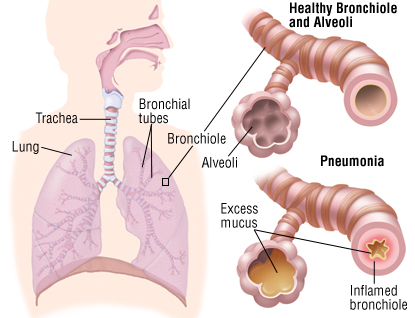

# Pneumonia Detection with Convolutional Neural Networks
Computer Vision can be realized using Convolutional neural networks (CNN) They are neural networks making features extraction over an image before classifying it. The feature extraction performed consists of three basic operations:

* Filter an image for a particular feature (convolution)
* Detect that feature within the filtered image (using the ReLU activation)
* Condense the image to enhance the features (maximum pooling)

# The convolution process is illustrated below

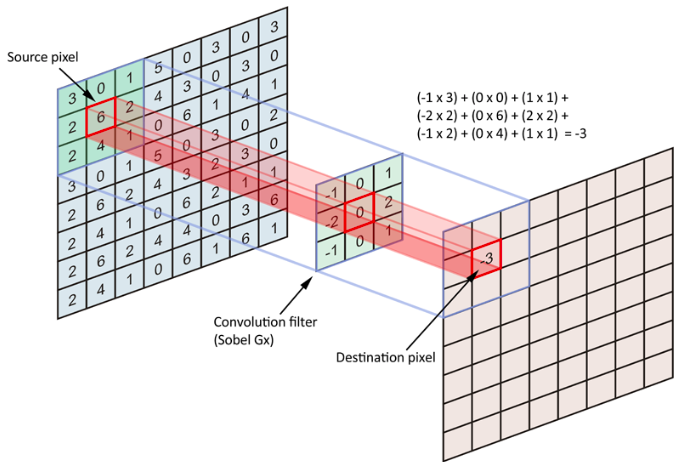

Using convolution filters with different dimensions or values results in differents features extracted

Features are then detected using the reLu activation on each destination pixel.

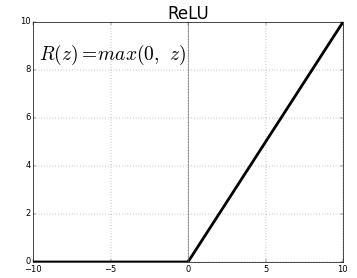

Features are the enhanced with MaxPool layers
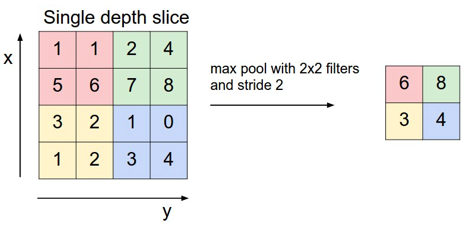

The stride parameters determines the distance between each filters. The padding one determines if we ignore the borderline pixels or not (adding zeros helps the neural network to get information on the border)

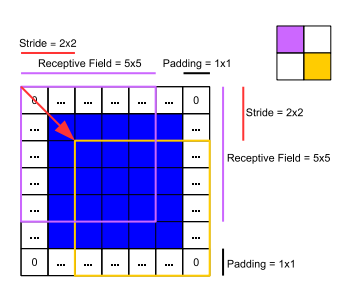

The outputs are then concatened in Dense layers

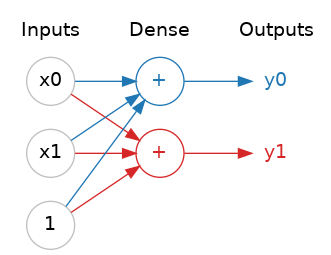

By using a sigmoid activation, the neural network determines which class the image belongs to
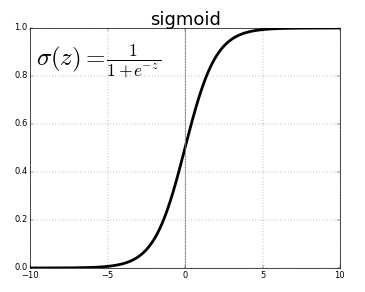

#  Import Packages and Functions
We'll make use of the following packages:

* numpy and pandas is what we'll use to manipulate our data
* matplotlib.pyplot and seaborn will be used to produce plots for visualization
* util will provide the locally defined utility functions that have been provided for this assignment
We will also use several modules from the keras framework for building deep learning models.

Run the next cell to import all the necessary packages.



In [9]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

os.listdir("chest_xray")

['.DS_Store', 'test', 'chest_xray', '__MACOSX', 'train', 'val']

In [10]:
len(os.listdir("chest_xray/train/PNEUMONIA"))

3875

The dataset is divided into three sets: 1) Train set 2) Validation set and 3) Test set.

# Data Visualization


Train set:
PNEUMONIA=3875
NORMAL=1341
Test set:
PNEUMONIA=390
NORMAL=234
Validation set:
PNEUMONIA=8
NORMAL=8


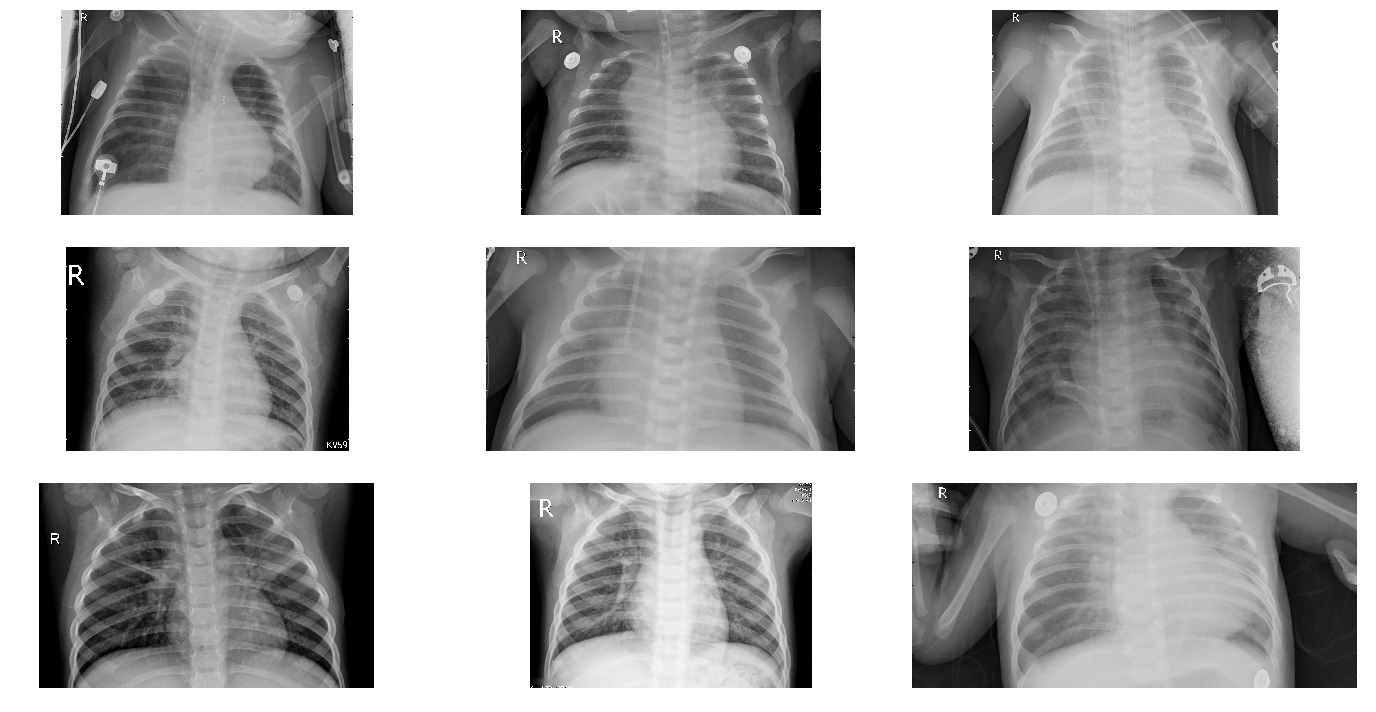

In [11]:
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"
val_dir = "chest_xray/val"

print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

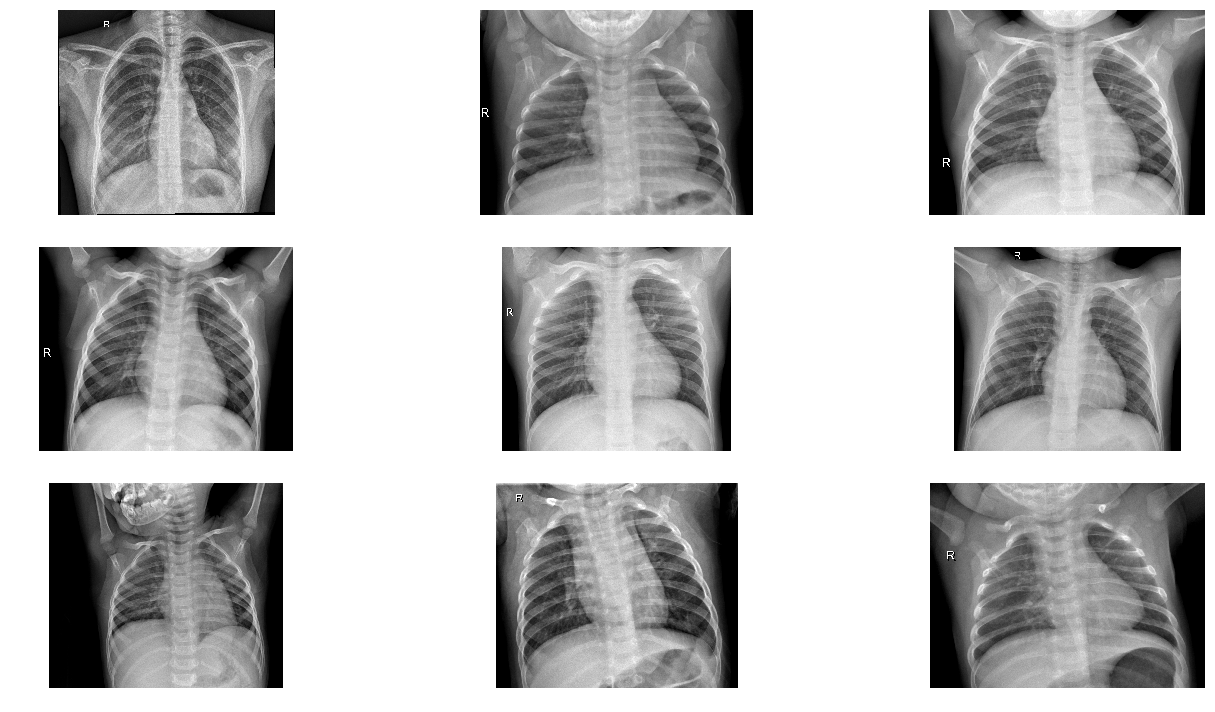

In [12]:
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

The dimensions of the image are 2234 pixels width and 2359 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 124.3910 and the standard deviation is 56.3308


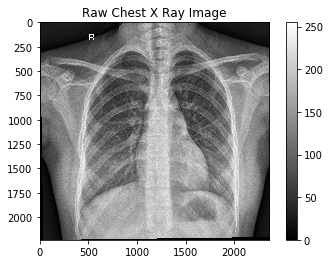

In [13]:
normal_img = os.listdir("chest_xray/train/NORMAL")[0]
normal_dir = "chest_xray/train/NORMAL"
sample_img = plt.imread(os.path.join(normal_dir, normal_img))
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

# Ivestigate pixel value distribution

Text(0,0.5,'# Pixels in Image')

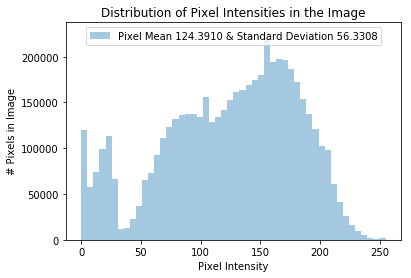

In [14]:
sns.distplot(sample_img.ravel(),
            label=f"Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

# 2. Image Preprocessing
Before training, we'll first modify your images to be better suited for training a convolutional neural network. For this task we'll use the Keras ImageDataGenerator function to perform data preprocessing and data augmentation.

This class also provides support for basic data augmentation such as random horizontal flipping of images.
We also use the generator to transform the values in each batch so that their mean is 0 and their standard deviation is 1 (this will faciliate model training by standardizing the input distribution).
The generator also converts our single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels (we will want this because the pre-trained model that we'll use requires three-channel inputs).

In [15]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

Using TensorFlow backend.


# Build a separate generator fo valid and test sets

Now we need to build a new generator for validation and t esting data.

Why can't use the same generator as for the training data?

Look back at the generator we wrote for the training data.

It normalizes each image per batch, meaning thatit uses batch statistics.
We should not do this with the test and validation data, since in a real life scenario we don't process incoming images a batch at a time (we process one image at a time).
Knowing the average per batch of test data would effectively give our model an advantage (The model should not have any information about the test data).
What we need to do is to normalize incomming test data using the statistics computed from the training set.

In [16]:
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(180, 180))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(180, 180))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(180, 180))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 180 pixels width and 180 pixels height, one single color channel.
The maximum pixel value is 3.3344 and the minimum is -2.7108
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


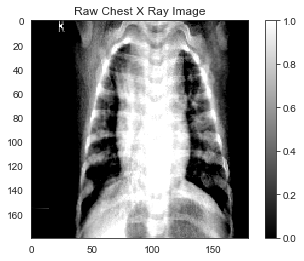

In [17]:
sns.set_style('white')
generated_image, label = train.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

Text(0,0.5,'# Pixels in Image')

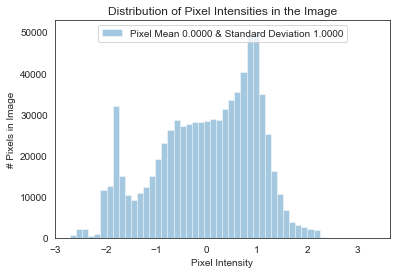

In [18]:
sns.distplot(generated_image.ravel(),
            label=f"Pixel Mean {np.mean(generated_image):.4f} & Standard Deviation {np.std(generated_image):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

# Building a CNN model

## Impact of imbalance data on loss function

Loss Function:
$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

We can rewrite the the overall average cross-entropy loss over the entire training set `D` of size `N` as follows:
$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$



When we have an imbalance data, using a normal loss function will result a model that bias toward the dominating class. One solution is to use a weighted loss function. Using weighted loss function will balance the contribution in the loss function.

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [19]:
# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


In [20]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization


model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 178, 178, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 176, 176, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 176, 176, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 86, 86, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 86, 86, 64)       

In [22]:
r = model.fit(
    train, 
    epochs=10,
    validation_data=validation, 
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 [==============================] - 99s 988ms/step - loss: 0.6044 - accuracy: 0.7950 - val_loss: 5.9454e-31 - val_accuracy: 0.3600
Epoch 2/10
100/100 [==============================] - 99s 994ms/step - loss: 0.2609 - accuracy: 0.8050 - val_loss: 65.1196 - val_accuracy: 0.6000
Epoch 3/10
100/100 [==============================] - 100s 998ms/step - loss: 0.1517 - accuracy: 0.8637 - val_loss: 1.0038e-04 - val_accuracy: 0.6000
Epoch 4/10
100/100 [==============================] - 117s 1s/step - loss: 0.1354 - accuracy: 0.8662 - val_loss: 10.5870 - val_accuracy: 0.5600
Epoch 5/10
100/100 [==============================] - 104s 1s/step - loss: 0.1595 - accuracy: 0.8525 - val_loss: 3.0751 - val_accuracy: 0.6400
Epoch 6/10
100/100 [==============================] - 104s 1s/step - loss: 0.1068 - accuracy: 0.8863 - val_loss: 9.6773 - val_accuracy: 0.4800
Epoch 7/10
100/100 [==============================] - 139s 1s/step - loss: 0.1015 - accuracy: 0.9087 - val_loss: 2.9222 - val

Text(0.5,1,'Accuracy Evolution')

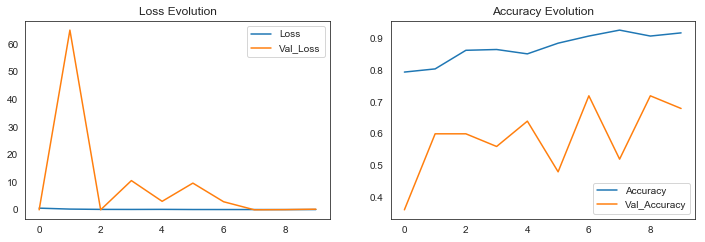

In [23]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [24]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 30s 49ms/step
Test Accuracy: 68.91%
652/652 [==============================] - 338s 518ms/step
Train Accuracy: 66.33%


In [25]:
from sklearn.metrics import confusion_matrix, classification_report

pred = model.predict(test)

print(confusion_matrix(test.classes, pred > 0.5))
pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True))

[[212  22]
 [169 221]]


0           1  micro avg   macro avg  weighted avg
precision    0.556430    0.909465    0.69391    0.732948      0.777077
recall       0.905983    0.566667    0.69391    0.736325      0.693910
f1-score     0.689431    0.698262    0.69391    0.693847      0.694950
support    234.000000  390.000000  624.00000  624.000000    624.000000

In [26]:
print(confusion_matrix(test.classes, pred > 0.7))
pd.DataFrame(classification_report(test.classes, pred > 0.7, output_dict=True))

[[219  15]
 [195 195]]


0           1   micro avg   macro avg  weighted avg
precision    0.528986    0.928571    0.663462    0.728778      0.778727
recall       0.935897    0.500000    0.663462    0.717949      0.663462
f1-score     0.675926    0.650000    0.663462    0.662963      0.659722
support    234.000000  390.000000  624.000000  624.000000    624.000000

# Transfer Learning
# DenseNet
Densenet is a convolutional network where each layer is connected to all other layers that are deeper in the network:

* The first layer is connected to the 2nd, 3rd, 4th etc.
* The second layer is conected to the 3rd, 4th, 5th etc.

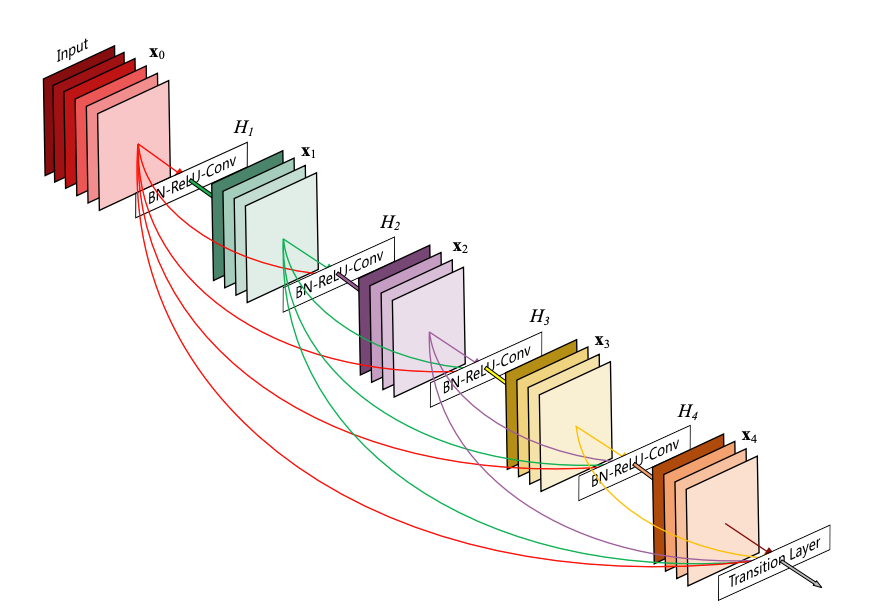

for more information about the DenseNet Architecture visit this website : https://keras.io/api/applications/densenet/


In [27]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

base_model = DenseNet121(input_shape=(180, 180, 3), include_top=False, weights='imagenet', pooling='avg')

base_model.summary()

29089792/29084464 [==============================] - 105s 4us/step
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 180, 180, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 186, 186, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 90, 90, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 90, 90, 64)   256         conv1/conv[0][0]                 
_____________________

In [28]:
layers = base_model.layers
print(f"The model has {len(layers)} layers")

The model has 428 layers


In [29]:
print(f"The input shape {base_model.input}")
print(f"The output shape {base_model.output}")

The input shape Tensor("input_1:0", shape=(None, 180, 180, 3), dtype=float32)
The output shape Tensor("avg_pool/Mean:0", shape=(None, 1024), dtype=float32)


In [30]:

#model = Sequential()
base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
#model.add(base_model)
#model.add(GlobalAveragePooling2D())
#model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [31]:
r = model.fit(
    train, 
    epochs=10,
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 [==============================] - 282s 3s/step - loss: 0.1591 - accuracy: 0.8225 - val_loss: 6.3827e-10 - val_accuracy: 0.6000
Epoch 2/10
100/100 [==============================] - 257s 3s/step - loss: 0.1254 - accuracy: 0.8487 - val_loss: 0.1827 - val_accuracy: 0.6800
Epoch 3/10
100/100 [==============================] - 299s 3s/step - loss: 0.1135 - accuracy: 0.8850 - val_loss: 0.0013 - val_accuracy: 0.5200
Epoch 4/10
100/100 [==============================] - 443s 4s/step - loss: 0.0822 - accuracy: 0.9112 - val_loss: 2.8382e-05 - val_accuracy: 0.5200
Epoch 5/10
100/100 [==============================] - 473s 5s/step - loss: 0.0912 - accuracy: 0.9050 - val_loss: 0.0051 - val_accuracy: 0.8000
Epoch 6/10
100/100 [==============================] - 501s 5s/step - loss: 0.0857 - accuracy: 0.9150 - val_loss: 0.0033 - val_accuracy: 0.6000
Epoch 7/10
100/100 [==============================] - 418s 4s/step - loss: 0.0759 - accuracy: 0.9275 - val_loss: 0.8174 - val_accuracy

Text(0.5,1,'Accuracy Evolution')

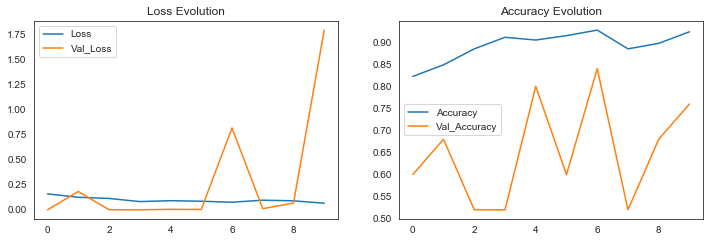

In [32]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [33]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 132s 211ms/step
Test Accuracy: 87.18%
652/652 [==============================] - 622s 954ms/step
Train Accuracy: 86.22%


# Evaluation

In [34]:
predicted_vals = model.predict(test, steps=len(test))

In [35]:
print(confusion_matrix(test.classes, predicted_vals > 0.5))
pd.DataFrame(classification_report(test.classes, predicted_vals > 0.5, output_dict=True))

[[191  43]
 [ 46 344]]


0           1   micro avg   macro avg  weighted avg
precision    0.805907    0.888889    0.857372    0.847398      0.857771
recall       0.816239    0.882051    0.857372    0.849145      0.857372
f1-score     0.811040    0.885457    0.857372    0.848249      0.857551
support    234.000000  390.000000  624.000000  624.000000    624.000000

# VGG16
Presented in 2014, VGG16 has a very simple and classical architecture, with blocks of 2 or 3 convolutional layers followed by a pooling layer, plus a final dense network composed of 2 hidden layers (of 4096 nodes each) and one output layer (of 1000 nodes). Only 3x3 filters are used.

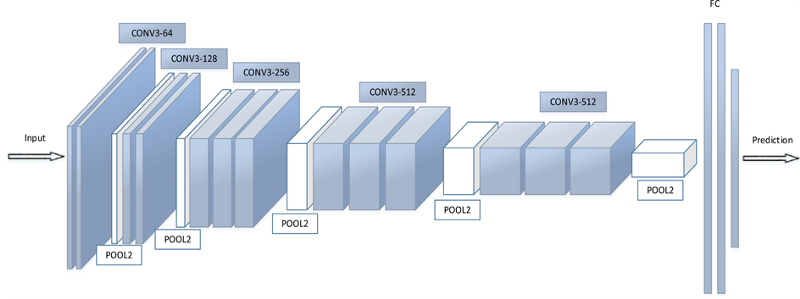

In [36]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
from keras.applications import VGG16


vgg16_base_model = VGG16(input_shape=(180,180,3),include_top=False,weights='imagenet')

    


58892288/58889256 [==============================] - 163s 3us/step


In [46]:
vgg16_base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 180, 180, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

In [56]:


    vgg16_model = Sequential([
        vgg16_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])
    
model = Sequential()
model.add(vgg16_model.layers[0])


In [57]:
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    vgg16_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=METRICS)

In [58]:
r = vgg16_model.fit(train,
          epochs=10,
          validation_data=validation,
          class_weight=class_weight,
          steps_per_epoch=100,
          validation_steps=25)



Epoch 1/10
100/100 [==============================] - 608s 6s/step - loss: 0.2452 - accuracy: 0.6550 - precision: 0.8610 - recall: 0.5777 - val_loss: 11.2919 - val_accuracy: 0.6400 - val_precision: 0.9089 - val_recall: 0.5950
Epoch 2/10
100/100 [==============================] - 873s 9s/step - loss: 0.2265 - accuracy: 0.6850 - precision: 0.9070 - recall: 0.6102 - val_loss: 3.0510 - val_accuracy: 0.6000 - val_precision: 0.8961 - val_recall: 0.6219
Epoch 3/10
100/100 [==============================] - 810s 8s/step - loss: 0.1883 - accuracy: 0.7563 - precision: 0.8988 - recall: 0.6407 - val_loss: 1.1226 - val_accuracy: 0.5600 - val_precision: 0.9096 - val_recall: 0.6538
Epoch 4/10
100/100 [==============================] - 863s 9s/step - loss: 0.1645 - accuracy: 0.7937 - precision: 0.9167 - recall: 0.6676 - val_loss: 10.1160 - val_accuracy: 0.5200 - val_precision: 0.9191 - val_recall: 0.6803
Epoch 5/10
100/100 [==============================] - 710s 7s/step - loss: 0.1868 - accuracy: 0.78

Text(0.5,1,'Accuracy Evolution')

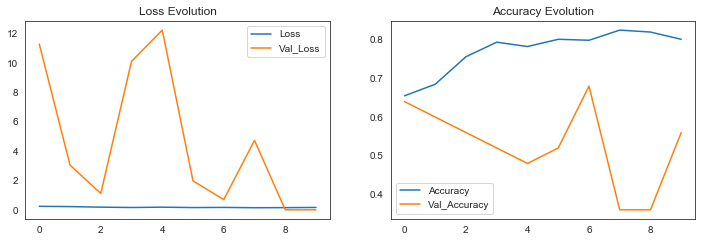

In [59]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [60]:
evaluation =vgg16_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = vgg16_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 226s 363ms/step
Test Accuracy: 66.19%
652/652 [==============================] - 1608s 2s/step
Train Accuracy: 82.63%


# ResNet

See the full explanation and schemes in the Research Paper on Deep Residual Learning (https://arxiv.org/pdf/1512.03385.pdf)

In [41]:
from keras.applications import ResNet50

resnet_base_model = ResNet50(input_shape=(180,180,3), include_top=False, weights='imagenet')



In [42]:
resnet_base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 180, 180, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 186, 186, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 90, 90, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 90, 90, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [62]:
    resnet_model = Sequential([
        resnet_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])

    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    resnet_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=METRICS)

In [63]:
r = resnet_model.fit(train,
          epochs=10,
          validation_data=validation,
          class_weight=class_weight,
          steps_per_epoch=100,
          validation_steps=25)


Epoch 1/10
100/100 [==============================] - 342s 3s/step - loss: 0.2744 - accuracy: 0.6250 - precision: 0.8261 - recall: 0.5821 - val_loss: 0.0000e+00 - val_accuracy: 0.3600 - val_precision: 0.8339 - val_recall: 0.6069
Epoch 2/10
100/100 [==============================] - 373s 4s/step - loss: 0.2067 - accuracy: 0.7638 - precision: 0.8585 - recall: 0.6394 - val_loss: 1.5493 - val_accuracy: 0.6000 - val_precision: 0.8706 - val_recall: 0.6762
Epoch 3/10
100/100 [==============================] - 393s 4s/step - loss: 0.1660 - accuracy: 0.8188 - precision: 0.8853 - recall: 0.7039 - val_loss: 18.2723 - val_accuracy: 0.5600 - val_precision: 0.8943 - val_recall: 0.7164
Epoch 4/10
100/100 [==============================] - 271s 3s/step - loss: 0.2083 - accuracy: 0.7275 - precision: 0.8941 - recall: 0.7136 - val_loss: 3.0410 - val_accuracy: 0.4800 - val_precision: 0.8918 - val_recall: 0.7145
Epoch 5/10
100/100 [==============================] - 252s 3s/step - loss: 0.2011 - accuracy: 0

Text(0.5,1,'Accuracy Evolution')

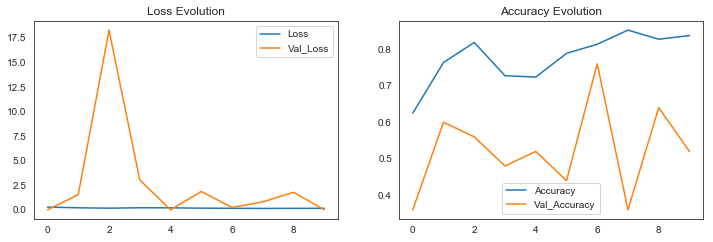

In [64]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [65]:
evaluation =resnet_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = resnet_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 101s 162ms/step
Test Accuracy: 73.40%
652/652 [==============================] - 651s 999ms/step
Train Accuracy: 88.92%


# InceptionNet
Also known as GoogleNet, this architecture presents sub-networks called inception modules, which allows fast training computing, complex patterns detection, and optimal use of parameters

for more information visit https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43022.pdf



In [66]:
from keras.applications import InceptionV3

inception_base_model = InceptionV3(input_shape=(180,180,3),include_top=False,weights='imagenet')



In [69]:
    inception_model = Sequential([
        inception_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])

    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    inception_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=METRICS)

In [70]:
r = inception_model.fit(train,
          epochs=10,
          validation_data=validation,
          class_weight=class_weight,
          steps_per_epoch=100,
          validation_steps=25)


Epoch 1/10
100/100 [==============================] - 295s 3s/step - loss: 0.3316 - accuracy: 0.5700 - precision: 0.8125 - recall: 0.5122 - val_loss: 1.3437 - val_accuracy: 0.6000 - val_precision: 0.8064 - val_recall: 0.5607
Epoch 2/10
100/100 [==============================] - 241s 2s/step - loss: 0.2538 - accuracy: 0.6513 - precision: 0.8185 - recall: 0.5756 - val_loss: 0.0000e+00 - val_accuracy: 0.4400 - val_precision: 0.8386 - val_recall: 0.5931
Epoch 3/10
100/100 [==============================] - 251s 3s/step - loss: 0.2044 - accuracy: 0.7538 - precision: 0.8514 - recall: 0.6160 - val_loss: 307.6369 - val_accuracy: 0.5600 - val_precision: 0.8633 - val_recall: 0.6344
Epoch 4/10
100/100 [==============================] - 217s 2s/step - loss: 0.2168 - accuracy: 0.7200 - precision: 0.8719 - recall: 0.6484 - val_loss: 344.6351 - val_accuracy: 0.5200 - val_precision: 0.8711 - val_recall: 0.6522
Epoch 5/10
100/100 [==============================] - 273s 3s/step - loss: 0.2289 - accuracy

Text(0.5,1,'Accuracy Evolution')

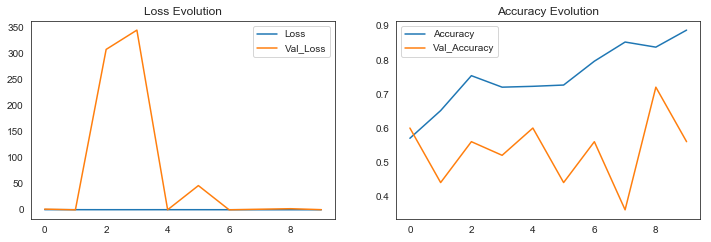

In [71]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [72]:
evaluation =inception_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = inception_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 41s 66ms/step
Test Accuracy: 76.76%
652/652 [==============================] - 295s 453ms/step
Train Accuracy: 91.26%


## Comparing different models

In [86]:
model_mae_scores_dict = {'CNN': 91.98, 'CNN_2': 68.91, 'DenseNet' : 87.18, 'VGG16' : 66.19, 'ResNet' : 73.40, 'InceptionNet' : 76.76}

In [87]:
model_mae_scores = pd.Series(model_mae_scores_dict)

In [88]:
model_mae_scores

CNN             91.98
CNN_2           68.91
DenseNet        87.18
VGG16           66.19
ResNet          73.40
InceptionNet    76.76
dtype: float64

In [89]:
order = model_mae_scores.sort_values()

Text(0.5,1,'Mean Average Error of All Models Tested')

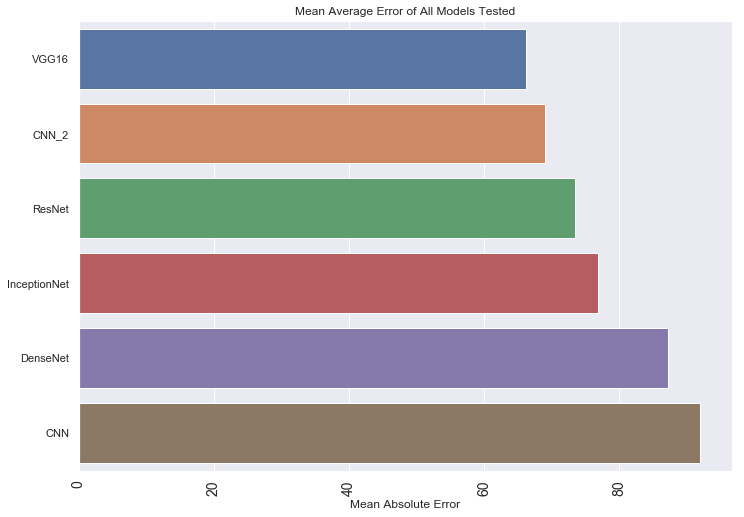

In [100]:
from matplotlib import pyplot
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x=order.values, y = order.index, orient='h')

plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')